<a href="https://colab.research.google.com/github/JasonLaux/DeepGlobe/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import cv2 
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# # Get the path of meta_data.csv.file
# base_path = os.getcwd()
# metadata_path = os.path.join(base_path, "drive/MyDrive/road-extraction/meta_data.csv")
# dataset_path = os.path.join(base_path, "drive/MyDrive/road-extraction/Road_Extraction_Dataset.zip (Unzipped Files)")

In [4]:
# Get the local path of meta_data.csv.file
base_path = os.getcwd()
metadata_path = os.path.join(base_path, "meta_data.csv")
dataset_path = os.path.join(base_path, "Road_Extraction_Dataset")

In [5]:
meta_data = pd.read_csv(metadata_path, index_col=False)

# Get training and test dataset index
dataset_index = meta_data[meta_data['split'] == 'train'][['sat', 'mask']]
test_dataset_index = meta_data[meta_data['split'] == 'test'][['sat', 'mask']]

# Split training dataset into 'train' and 'validation'
# Shuffle indices 
dataset_shuffled = dataset_index.sample(frac=1, ignore_index=True)

train_dataset_index = dataset_shuffled[:4180]
validate_dataset_index = dataset_shuffled[4180:]

# Reset index
validate_dataset_index.reset_index(drop=True, inplace=True)
test_dataset_index.reset_index(drop=True, inplace=True)

print("Length of training set: ", len(train_dataset_index))
print("Length of validation set: ", len(validate_dataset_index))
print("Length of test set: ", len(test_dataset_index))

print("First row of metadata: \n", meta_data.head(1))
print("First 10 rows of training dataset: \n", train_dataset_index.head(10))
print("First 10 rows of test dataset: \n", test_dataset_index.head(10))



Length of training set:  4180
Length of validation set:  1046
Length of test set:  1000
First row of metadata: 
    split             sat             mask
0  train  100034_sat.jpg  100034_mask.png
First 10 rows of training dataset: 
               sat             mask
0  122312_sat.jpg  122312_mask.png
1  307151_sat.jpg  307151_mask.png
2  212985_sat.jpg  212985_mask.png
3  500322_sat.jpg  500322_mask.png
4  464724_sat.jpg  464724_mask.png
5  425216_sat.jpg  425216_mask.png
6  608782_sat.jpg  608782_mask.png
7  390893_sat.jpg  390893_mask.png
8  210375_sat.jpg  210375_mask.png
9  439073_sat.jpg  439073_mask.png
First 10 rows of test dataset: 
               sat             mask
0  851461_sat.jpg  851461_mask.png
1  851693_sat.jpg  851693_mask.png
2  851977_sat.jpg  851977_mask.png
3  852056_sat.jpg  852056_mask.png
4  852071_sat.jpg  852071_mask.png
5   85211_sat.jpg   85211_mask.png
6  852321_sat.jpg  852321_mask.png
7  852350_sat.jpg  852350_mask.png
8  852387_sat.jpg  852387_mask.pn

In [ ]:
# Display the original image and the mask image in the first raw
example_sat_path = os.path.join(dataset_path, train_dataset_index.loc[0, 'sat'])
example_mask_path = os.path.join(dataset_path, train_dataset_index.loc[0, 'mask'])
sat = cv2.imread(example_sat_path)
mask = cv2.imread(example_mask_path, cv2.IMREAD_GRAYSCALE)
mask_bw = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)[1]
print("Original satellite image shape: ", sat.shape)
print("Grayscale mask image shape: ", mask.shape)
print("Binary mask image: \n", mask_bw)
# fig, ax = plt.subplots(3, 1)
# ax[0].imshow(cv2.cvtColor(sat, cv2.COLOR_BGR2RGB))
# ax[0].set_title("Original satellite image")
# ax[1].imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
# ax[1].set_title("Grayscale mask image")
# ax[2].imshow(mask_bw, cmap='gray')
# ax[2].set_title("Binary mask image(threshold value=128)")
# plt.show()

fig1 = plt.figure()
plt.imshow(cv2.cvtColor(sat, cv2.COLOR_BGR2RGB))
plt.title("Original satellite image")
fig2 = plt.figure()
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.title("Grayscale mask image")
fig3 = plt.figure()
plt.imshow(mask_bw, cmap='gray')
plt.title("Binary mask image")
plt.show()


In [34]:
width, height = 128, 128


def dataLoader(indexFile, img_width, img_height):
    """
    This function will read image data based on index files.

    :param indexFile : the index dataFrame contains image names of satellite and mask image pairs
    :param img_width : the width of resized image
    :param img_height: the height of resized image
    :return      : return satellite and mask image data. General shape: (No. samples, width, height, No. channels)
    """
    
    num_samples = len(indexFile)
    
    input_scale = (img_width, img_height)
    
    sat = np.empty([num_samples, width, height, 3], dtype = 'float64')
    mask = np.empty([num_samples, width, height, 1], dtype = 'float64')
    
    for i in range(num_samples):
        # Read the satellite image and the cooresponding mask image
        sat_img = cv2.imread(os.path.join(dataset_path, indexFile.loc[i, 'sat']))
        sat_img = sat_img / 255
        mask_gray_img = cv2.imread(os.path.join(dataset_path, indexFile.loc[i, 'mask']), cv2.IMREAD_GRAYSCALE)

        # Binarize mask image. Threshold is 128.
        mask_bw = cv2.threshold(mask_gray_img, 128, 1, cv2.THRESH_BINARY)[1]

        # Resize images to (width, height)
        resized_sat= cv2.resize(sat_img, input_scale, interpolation = cv2.INTER_CUBIC)
        resized_mask= cv2.resize(mask_bw, input_scale, interpolation = cv2.INTER_CUBIC)

        # Expand another dim 
        resized_mask = np.expand_dims(resized_mask, axis=-1)
        
        sat[i] = resized_sat
        mask[i] = resized_mask

        if (i + 1) % 100 == 0:
          print("Total number of training samples that has been processed:", i + 1, " Total: ", num_samples)
    
    return sat, mask

train_sat, train_mask = dataLoader(train_dataset_index, width, height)
val_sat, val_mask = dataLoader(validate_dataset_index, width, height)
test_sat, test_mask = dataLoader(test_dataset_index, width, height)


print(train_sat.shape)
print(train_mask.shape)

print(val_sat.shape)
print(val_mask.shape)

print(test_sat.shape)
print(test_mask.shape)





Total number of training samples that has been processed: 100  Total:  4180
Total number of training samples that has been processed: 200  Total:  4180
Total number of training samples that has been processed: 300  Total:  4180
Total number of training samples that has been processed: 400  Total:  4180
Total number of training samples that has been processed: 500  Total:  4180
Total number of training samples that has been processed: 600  Total:  4180
Total number of training samples that has been processed: 700  Total:  4180
Total number of training samples that has been processed: 800  Total:  4180
Total number of training samples that has been processed: 900  Total:  4180
Total number of training samples that has been processed: 1000  Total:  4180
Total number of training samples that has been processed: 1100  Total:  4180
Total number of training samples that has been processed: 1200  Total:  4180
Total number of training samples that has been processed: 1300  Total:  4180
Total nu

In [35]:
class Autoencoder:

    def build(width, height, depth):
        
        encoder_filters = (32, 64, 128)
        decoder_filters = (64, 32, 1)
        # initialize the input shape
        inputShape = (height, width, depth)
        # define the input to the encoder
        inputs = Input(shape=inputShape)
        x = inputs
        # construct encoder
        for f in encoder_filters:
            # apply a CONV => RELU => BN operation
            x = Conv2D(f, (5, 5), kernel_initializer = 'he_normal')(x)
            x = ReLU()(x)

        # loop through filters in the reverse order to construct decoder
        for f in decoder_filters:
            # apply a CONV_TRANSPOSE => RELU => BN operation
            x = Conv2DTranspose(f, (5, 5))(x)
            x = ReLU()(x)
        # apply a single CONV_TRANSPOSE layer used to recover the
        # binary mask image
#         x = Conv2DTranspose(1, (5, 5))(x)
#         outputs = Activation("relu", name="decoded")(x)
        # construct our autoencoder model
        autoencoder = Model(inputs=inputs, outputs=x, name="autoencoder")
        # return the autoencoder model
        return autoencoder

In [36]:
autoencoder = Autoencoder.build(128, 128, 3)
autoencoder.summary()
autoencoder.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 124, 124, 32)      2432      
_________________________________________________________________
re_lu_30 (ReLU)              (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 120, 120, 64)      51264     
_________________________________________________________________
re_lu_31 (ReLU)              (None, 120, 120, 64)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 116, 116, 128)     204928    
_________________________________________________________________
re_lu_32 (ReLU)              (None, 116, 116, 128)     

In [37]:
EPOCHS = 3
BATCH_SIZE = 100

model = autoencoder.fit(train_sat, train_mask, validation_data=(val_sat, val_mask), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/3
42/42 [==============================] - 1366s 33s/step - loss: 0.7513 - accuracy: 0.9200 - val_loss: 0.1624 - val_accuracy: 0.9591
Epoch 2/3
42/42 [==============================] - 1361s 32s/step - loss: 0.1580 - accuracy: 0.9588 - val_loss: 0.1554 - val_accuracy: 0.9591
Epoch 3/3
42/42 [==============================] - 1319s 31s/step - loss: 0.1528 - accuracy: 0.9588 - val_loss: 0.1494 - val_accuracy: 0.9591


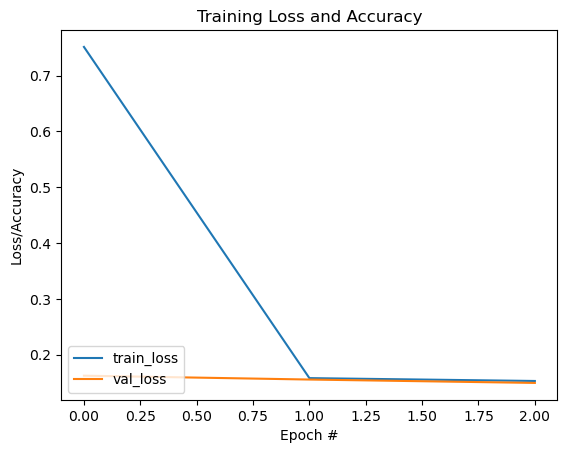

In [38]:
# Draw loss accuracy in the training and validation dataset during training
N = np.arange(0, EPOCHS)
plt.figure()
plt.plot(N, model.history["loss"], label="train_loss")
plt.plot(N, model.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

(10, 128, 128, 1)


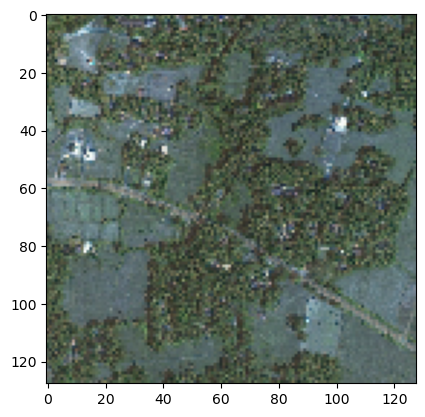

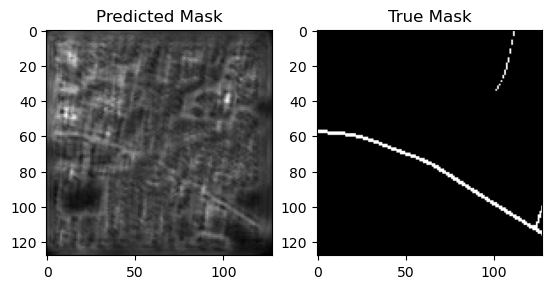

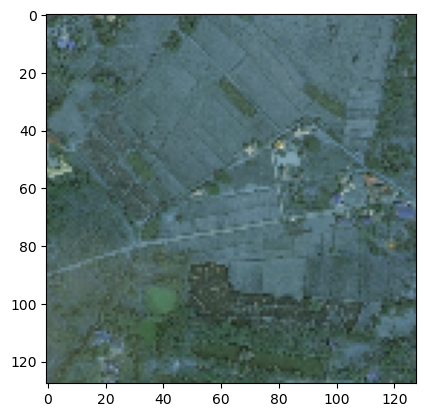

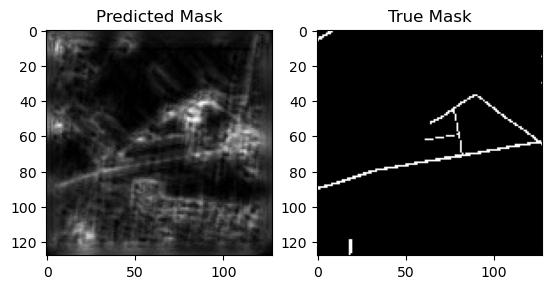

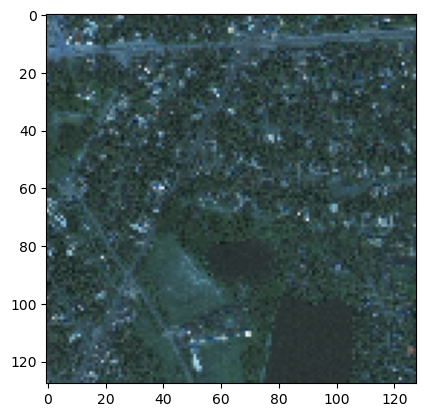

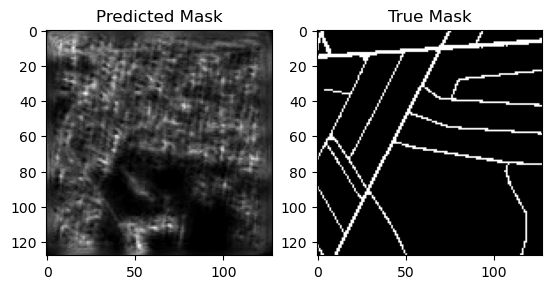

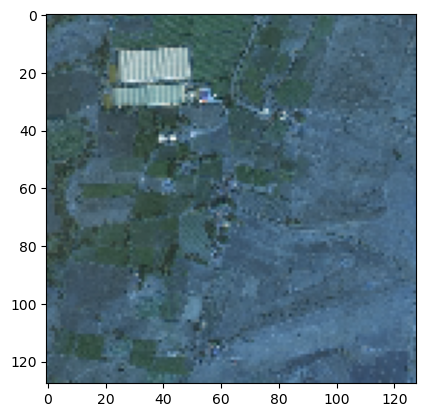

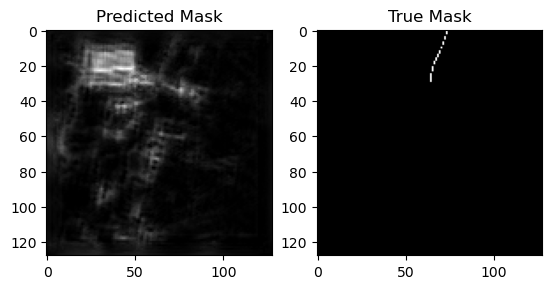

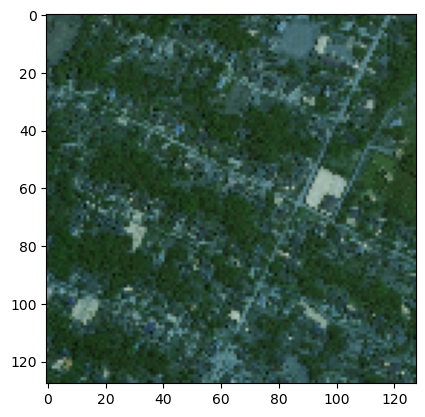

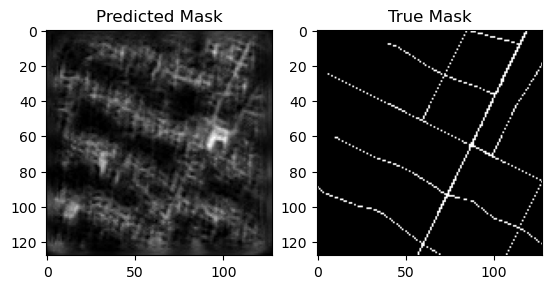

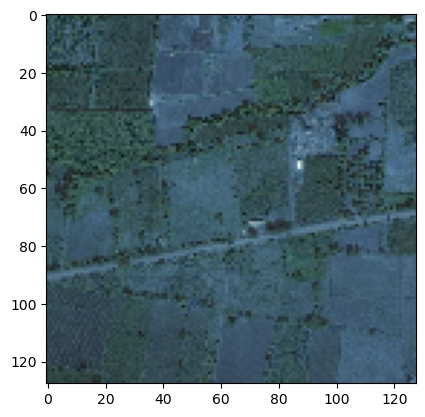

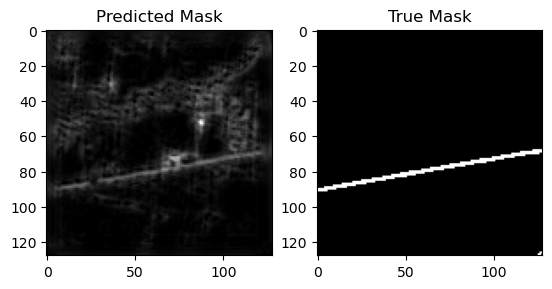

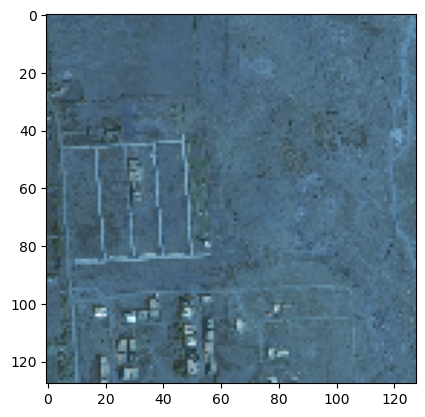

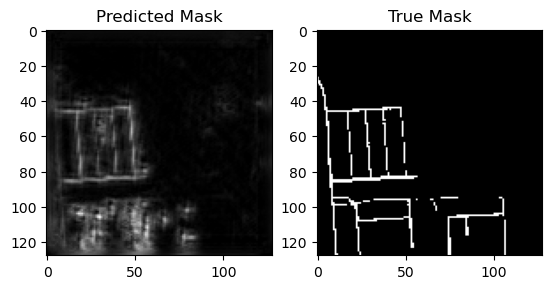

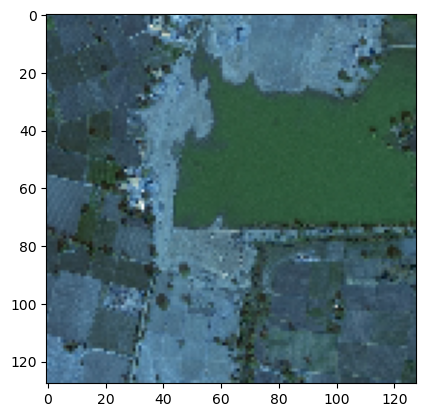

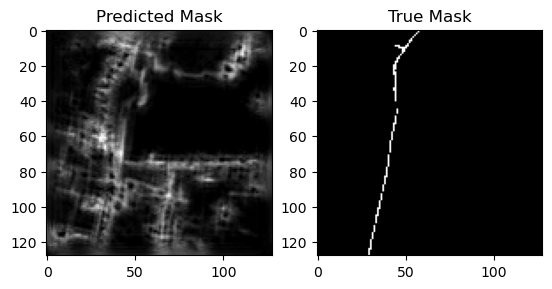

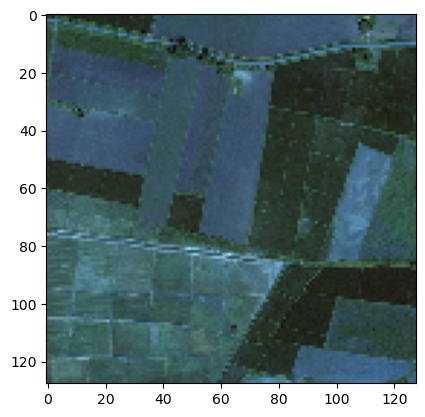

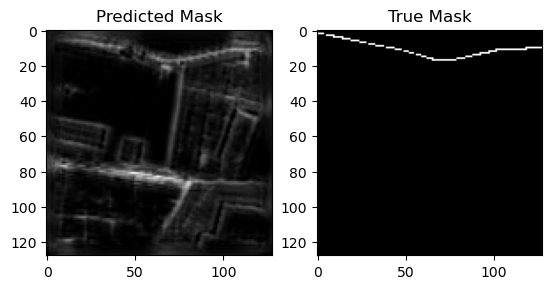

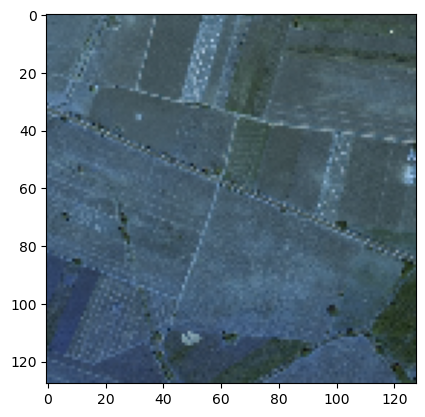

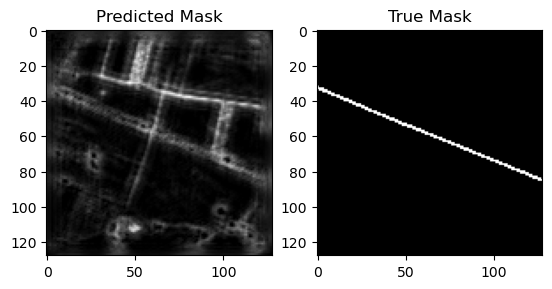

In [41]:
num_display = 10
pred_mask = autoencoder.predict(test_sat[:num_display])
print(pred_mask.shape)

true_mask = test_mask[:num_display]
for i in range(num_display):
    fig = plt.figure()
    plt.imshow(test_sat[i, :, :, :])
    fig_sub, ax = plt.subplots(1, 2)
    ax[0].imshow(pred_mask[i], cmap='gray')
    ax[0].set_title("Predicted Mask")
    ax[1].imshow(true_mask[i], cmap='gray')
    ax[1].set_title("True Mask")
    plt.show()